## Introduction
This tutorial will introduce you to Tensorflow, an open-source machine learning framework for numerical computation using dataflow graphs. We'll learn how to implement multi-layer perceptrons in Tensorflow using a dataset of malicious and benign URLs, creating a classifier for identifying malicious URLs.

### Background

We'll use a "Hidden Fraudulent URLs" dataset provided by researchers at the University of Trieste, Italy. The dataset includes three kinds of URLs:

1. Hidden Fraudulent URLs
2. URLs of legitimate pages from trusted, but compromised websites
3. URLs of legitimate pages from trusted, uncompromised websites

Let's take a closer look at these terms.

- __Hidden URL__: a URL not reached by crawling the website within up to the third level of depth.

- __Hidden Fraudulent URL__: a URL to an illegitimate webpage that was added to a trusted website. 

### Tutorial content

We'll cover the following topics in this tutorial:
- [Installing Libraries](#Installing-Libraries)
- [Introduction to Tensorflow](#Introduction-to-Tensorflow)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Training and Test Data](#Training-and-Test-Data)
- [Feature Columns](#Feature-Columns)
- [Choosing the Model](#Choosing-the-Model)
- [Training and Evaluation](#Training-and-Evaluation)
- [Results](#Results)

## Installing Libraries

First, install Tensorflow and the tld module (for parsing URLs).  You can install them via `pip`:
    
    $ pip install tensorflow
    
    $ pip install tld
    
Next, make sure the following imports work for you:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf # need to run pip install tensorflow
import pandas as pd
import numpy as np
import math
from urllib.parse import urlparse
from tld import get_tld # need to run pip install tld
from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

/Users/vivekshankar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Introduction to Tensorflow

We begin with a short excursion into the low-level TensorFlow API: Tensorflow Core. For the remainder of the tutorial, we'll be using higher-level Estimator APIs, but it's still good to know the underlying structure of Tensorflow programs.

In Tensorflow, the main data structure is the **tensor**: an array of values. A **computational graph** contains:

1. **Operations**: nodes in the graph. Operations describe calculations that take input tensors and output tensors.

2. **Tensors**: edges in the graph. These represent values that flow through the graph.

Below is a simple **computational graph** we'll create: [<img src="https://github.com/VivekShankar/Tutorial/raw/master/CompGraph.png">](https://github.com/VivekShankar/Tutorial/raw/master/CompGraph.png)

You can think of a Tensorflow program in two stages: 

1. Building the graph

2. Running the graph

Run the following snippet to create a computational graph. 

In [33]:
# Create two floating point constants a and b using tf.constant
# tf.constant builds the constant operation from a float.
a = tf.constant(1.4) 
b = tf.constant(4.0)
# Apply the "*" operation to multiply the two tensors.
total = a * b
print(a)
print(b)
print(total)

Tensor("Const_2:0", shape=(), dtype=float32)
Tensor("Const_3:0", shape=(), dtype=float32)
Tensor("mul_1:0", shape=(), dtype=float32)


Note: printing the tensors does not output the values 1.4, 4.0, and 5.6, as you might expect. The code only builds the graph. To run the graph, create a `tf.Session` object and call its `run` method.

In [34]:
sess = tf.Session()
print(sess.run(total))

5.6


Congratulations, you've run your first Tensorflow program! We've come to the end of our short exploration of Tensorflow Core - you should be familiar with basic Tensorflow terminology and how Tensorflow programs work behind the scenes. For more information, check out: https://www.tensorflow.org/programmers_guide/low_level_intro.

## Exploratory Data Analysis

Now that we've got our feet wet with Tensorflow, check out the following link to load the URLs dataset: http://machinelearning.inginf.units.it/data-and-tools/hidden-fraudulent-urls-dataset. Download the `HiddenFraudulentURLs.zip` file, unzip the file to extract `HiddenFraudulentURLs.csv`, and load the data using Pandas. 

In [4]:
df_urls = pd.read_csv("HiddenFraudulentURLs.csv", sep=";")
df_urls.head()

,url,compromissionType,isHiddenFraudulent,contentLength,serverType,poweredBy,contentType,lastModified
0,http://www.sinduscongoias.com.br/index.html,defacement,False,2474,Apache/2.2,NaN,text/html,"Sat, 05 Jan 2013 19:36:29 GMT"
1,http://www.sinduscongoias.com.br/index.php/ins...,defacement,False,0,Apache/2.2,NaN,text/html; charset=utf-8,"Mon, 21 Jan 2013 19:30:53 GMT"
2,http://www.sinduscongoias.com.br/index.php/ins...,defacement,False,0,Apache/2.2,NaN,text/html; charset=utf-8,"Mon, 21 Jan 2013 19:30:58 GMT"
3,http://www.sinduscongoias.com.br/index.php/ins...,defacement,False,0,Apache/2.2,NaN,text/html; charset=utf-8,"Mon, 21 Jan 2013 19:31:01 GMT"
4,http://www.sinduscongoias.com.br/index.php/ins...,defacement,False,0,Apache/2.2,NaN,text/html; charset=utf-8,"Mon, 21 Jan 2013 19:31:05 GMT"


Inspecting the data, we notice several missing values (NaNs). To avoid errors in Tensorflow, we replace NaNs with empty strings. Our goal is to predict whether the URL is fraudulent (predict the `isHiddenFraudulent` column). For binary classification, Tensorflow expects that the label has values 1 (fraudulent) or 0 (benign): we cast `isHiddenFraudulent` to an integer.

In [8]:
df_urls.fillna('', inplace=True)
df_urls["isHiddenFraudulent"] = df_urls["isHiddenFraudulent"].astype(int)

For EDA, we examine the data and basic **categorical** features we're provided with through bar charts. For example, here's a bar chart showing the distribution of the `isHiddenFraudulent` variable.

<BarContainer object of 2 artists>

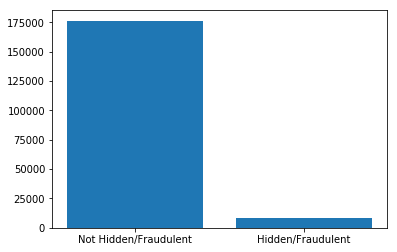

In [9]:
# Count the number of URLs in each category: fraudulent or not fraudulent
counts = collections.Counter(df_urls["isHiddenFraudulent"])
plt.bar(range(len(counts)), list(counts.values()), 
        tick_label=["Not Hidden/Fraudulent", "Hidden/Fraudulent"])

The distribution is skewed heavily towards non-fraudulent URLs: over 95% are benign! Keep this in mind later, when we're evaluating our Tensorflow model.

## Feature Engineering

Let's do feature engineering to augment our dataset. Rather than passing the entire URL as a feature, let's break it into its constituent parts. Here's the general URL structure: `scheme://netloc/path;parameters?query#fragment`. We'll extract some of these features in the function below.

In [10]:
def create_url_features(url_series):
    '''Takes in a Pandas Series object containing the URLs and returns 
       a dictionary of new features. For each entry in the result, 
       the key is the name of the new feature, and the value is a list 
       containing all the values for that feature.'''
    
    # Example URL: http://www.google.com/a/b/c/search?q=search&lang=en
    features = {"schema": [], # http
                "netloc" : [], # www.google.com
                "path" : [], # a/b/c/search?q=search&lang=en
                "log_len_path" : [], # log(len("a/b/c/search?q=search&lang=en")) = 4
                "tld" : [], # com
                "domain": []} # google
    
    for url in url_series:
        o = urlparse(url) # parse the URL using urlparse to extract its scheme, netloc, and path
        features["schema"].append(o.scheme) 
        features["netloc"].append(o.netloc)
        features["path"].append(o.path)
        # Add 1 to the length before taking log to avoid 'log(0)' errors
        features["log_len_path"].append(round(math.log(len(o.path) + 1, 2)))
        try:
            tld_object = get_tld(url, as_object=True) # get the tld and domain using tld.get_tld
            features["tld"].append(tld_object.suffix)
            features["domain"].append(tld_object.domain)
        except: # exception in extracting the TLD
            features["tld"].append("")
            features["domain"].append("")
    return features

Let's add these features as columns into our dataframe.

In [11]:
def add_features_to_df(df):
    '''Calls create_url_features on the list of URLs in the dataframe to 
       create a dictionary of new features. Adds the new features as new 
       columns in the original dataframe and returns the modified dataframe'''
    
    # create the features dictionary
    features = create_url_features(df["url"]) 
    for feature in features: # loop through the dict & add the features as cols
        df[feature] = features[feature]
    return df

df_urls = add_features_to_df(df_urls)

From the `lastModified` timestamp, we'll extract the **year** as another feature. First, we convert the timestamp string into a `datetime` object. However, since the data doesn't follow one specific datetime format string, we cycle through several possibilities. If there's no `lastModified` timestamp for an example, or we're unable to extract a year, we return a default value of 0. 

In [12]:
from datetime import datetime

def extractTime(time):
    '''Returns the year (of type: int) from the 'time' timestamp string, 
       if possible. Returns 0 otherwise'''
    
    if time == '':
        return 0
    formats = ['%a, %d %b %Y %H:%M:%S %Z', 
               '%a, %d %b %Y %H:%M:%S%Z', 
               '%a, %d %b %Y %H:%M:%S %z', 
               '%a %d %b %Y %H:%M:%S %Z', 
               '%a, %d %b %Y %H:%M:%S %Z %z'] # possible datetime format strings
    for fmt in formats:
        try: # try to convert the lastModified string to a dateTime
            d = datetime.strptime(time, fmt)
            return d.year
        except ValueError: # try a different datetime format string
            pass
    return 0

df_urls["year"] = df_urls["lastModified"].apply(lambda time : extractTime(time))

Great, we've now extracted features from the raw URLs! How can we tell how good our features are? One way of investigating feature quality is by determining whether a feature is **strongly correlated** with the label. For example, suppose the TLD ".ru" appeared in fraudulent URLs 96.7% of the time. Then, the TLD is good at "separating" the data: ".ru" is strongly correlated with fraudulent URLs. We can visually inspect the correlation of a **categorical** feature with the label by plotting a **heat map** of the label vs. the feature. We present a heat map of the label vs. tld for the first 1000 examples.

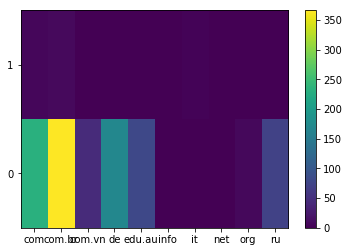

In [17]:
numExamples = 1000
tld, label = df_urls["tld"], df_urls["isHiddenFraudulent"]

# Extract the list of unique tlds, assign each tld in the list of tlds
# an index" representing which tld in the list of unique tlds it is
unique_tlds, tld_ids = np.unique(tld[:numExamples], return_inverse=True)
# Repeat above steps for the label
unique_labels, label_ids = np.unique(label[:numExamples], return_inverse=True)

# Create the heat map plot
_, xt, yt, _ = plt.hist2d(tld_ids, label_ids, bins=(len(unique_tlds), len(unique_labels)))
plt.xticks((xt[:-1]+xt[1:])/2, unique_tlds) # Add tick-marks for the x and y axes
plt.yticks((yt[:-1]+yt[1:])/2, unique_labels)

# Show heat map
plt.colorbar()

Each cell corresponds with a row (1=malicious, 0=benign), and a column (TLD). The cell's color indicates the number of instances of the TLD in a class. For example, ".edu" appears in malicious URLs <25 times, and in benign URLs around 100 times.

## Training and Test Data

Next, we parse the data into training and test sets. We'll split the `df_urls` dataframe such that 80% of the examples are in the training set, and 20% are in the test set. It's important to randomize the data before splitting between training/test sets so that the distribution of the features and the label in the training and test sets match their overall distribution in the original dataset. 

In [18]:
def load_data(df, label_name="isHiddenFraudulent", split_ratio=0.8):
    '''Shuffles the rows of the data frame and splits the raw input 
       data into training and testing sets'''
    
    # Returns two tuples of (feature, label) for the training and test sets.
    df = shuffle(df) # shuffle the rows of the data frame randomly
    num_rows = df.shape[0]
    split_point = int(num_rows*split_ratio)
    train, test = df[:split_point], df[split_point:]

    # 1. Delete (pop) the labels from the DataFrame, 
    # and assign the labels to train_y/test_y
    # 2. Assign the remainder of the DataFrame to train_x/test_x
    train_x, train_y = train, train.pop("isHiddenFraudulent")
    test_x, test_y = test, test.pop("isHiddenFraudulent")
    
    return (train_x, train_y), (test_x, test_y)

(train_x, train_y), (test_x, test_y) = load_data(df_urls)

### Feature Columns

#### String Features
We'll convert our features into **feature columns** (data structure in Tensorflow to describe how to interpret different feature types). For us, most features are strings. Neural Networks work best on numbers (e.g.: `tf.float32`). We use `tf.feature_column.categorical_column_with_vocabulary_list` that takes in a "vocabulary list" of all the unique string-values of the feature, and maps each string to an integer. Then, each string will be represented as a one-hot vector.

In [20]:
string_features = ["schema", "netloc", "path", "tld", "domain"]
vocab_feature_columns = []
for key in string_features:
    # Get a list of the unique feature values (vocabulary list)
    vocab_list = df_urls[key].unique()
    vocab_length = len(vocab_list)
    
    # create a vocabulary feature column that converts each string 
    # to a one-hot vector using the index of the string in the vocab_list
    vocabulary_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(
        key=key,
        vocabulary_list=vocab_list)
    vocab_feature_columns.append((vocabulary_feature_column,vocab_length))

For features like the domain, we have a **lot** of possible classes, (around 10<sup>5</sup>)! It's hard to train neural nets as the number of categories becomes large - the one-hot vectors grow proportionally! Instead of representing the data using large one-hot vectors, we can use **embedding columns**. Embeddings represent data as lower-dimensional, dense vectors. Below, we convert the categorical feature columns into embedding columns.

In [21]:
my_feature_columns = []
for (vocabulary_feature_column, vocab_length) in vocab_feature_columns:
    my_feature_columns.append(tf.feature_column.embedding_column(
        categorical_column=vocabulary_feature_column,
        dimension=math.ceil(vocab_length ** 0.25)))

How do we choose the dimension of our embedding column? We use a rule of thumb: the length of the embedding column is the 4th root of the number of categories. How do we find the concrete values for each embedding vector corresponding to a string? The answer: during training of the neural network. As we train our model, we learn values of our embedding vectors to satisfy amazing properties, such as nearby strings having vectors lying close together in the embedding space!

#### Numerical Features

For `log(len(path))` (and other numerical features), we can use `tf.feature_column.numeric_column` and specify the `dtype` argument to differentiate between different numerical datatypes: `int32`, `float64`, etc.

In [22]:
my_feature_columns.append(tf.feature_column.numeric_column(key="log_len_path", dtype=tf.float64))

For `lastModified`, we'll split the feature into buckets within specific year ranges (e.g.: [before 2000, 2000-2005, 2005-2010, etc]). We can use the `tf.feature_column.bucketized_column` method.

In [23]:
numeric_feature_column = tf.feature_column.numeric_column(key="year")
bucketized_feature_column = tf.feature_column.bucketized_column(
    source_column = numeric_feature_column,
    boundaries = [2000, 2005, 2010, 2011, 2012, 2013])
my_feature_columns.append(bucketized_feature_column)

### Choosing the Model

Tensorflow provides many model types, but we'll use a neural network for this exercise. In this tutorial, we assume a working knowledge of neural networks, but for a refresher, we recommend the following chapter from Michael Nielson's online book: http://neuralnetworksanddeeplearning.com/chap1.html 

A Tensorflow model is an `Estimator` object. Tensorflow has two major classes: pre-made and custom Estimators, that you'll code yourself. Tensorflow has a premade, fully-connected neural network Estimator. Run the cell below to create a `tf.estimator.DNNClassifier`.

In [41]:
# Pass in the list of feature columns: feature_columns=my_feature_columns
# Pass in a list describing the specific neural network architecture: hidden_units=[50,50]
classifier = tf.estimator.DNNClassifier( #DNN = deep neural network
    feature_columns=my_feature_columns, 
    # Three hidden layers: 1024 nodes in the 1st layer, 512 in the 2nd, 256 in the 3rd
    # (ith element in list = # nodes in ith hidden layer)
    hidden_units=[1024, 512, 256],
    dropout = 0.05,
    optimizer=tf.train.ProximalAdagradOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.001),
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/l4/kglg4bbd4y1c4jgqsvgqbs500000gn/T/tmp0en6_hm1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a1f6fc668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Let's go over the **tunable hyperparameters** we supplied. 
1. `hidden_units`: list describing the neural network architecture: # hidden layers, nodes per layer.
2. `ProximalAdagradOptimizer` optimizer: method for optimizing the network’s loss function that you can read more about here: https://cs.stanford.edu/~ppasupat/a9online/1107.html.
3. `learning_rate=0.1`: indicates how far to move a neuron’s weights in the direction of the gradient during backpropagation.
4. `dropout=0.05`: regularization technique for neural networks, represents the probability we remove neurons from the network. Removing neurons allows the network to avoid incorporating every neuron while making classification decisions and helps avoid overfitting in large networks.

It's a good idea to run experiments with different hyperparameters on a validation set to determine suitable hyperparameter values for the network. For more information on the parameters you can supply to `DNNClassifier`, check out https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier.

### Training and Evaluation

To train the network, we provide an `input_fn` (`train_input_fn` below), to input training data into the model. `train_input_fn` takes in `features`, a Pandas dataframe containing our training data (row=example, column=feature). `labels` is a list of labels for each example. `batch_size` indicates the number of examples to process at a time (before performing a gradient update). Training neural nets works best when the order of examples is randomized - call `tf.data.Dataset.shuffle` to shuffle the training data. 

In [42]:
def train_input_fn(features, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Randomize the examples and group them in batches
    dataset = dataset.shuffle(buffer_size=1000).repeat().batch(batch_size)
    return dataset

Let's call the `train` method of the `DNNClassifier` to train the model, passing `train_input_fn` to input the training data and the number of steps to train the model (another hyperparameter).

In [43]:
batch_size = 100
train_steps = 10000

# Train the Model.
classifier.train(
    input_fn=lambda:train_input_fn(train_x, train_y, batch_size),
    steps=train_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l4/kglg4bbd4y1c4jgqsvgqbs500000gn/T/tmp0en6_hm1/model.ckpt.
INFO:tensorflow:loss = 72.51943, step = 1
INFO:tensorflow:global_step/sec: 35.5732
INFO:tensorflow:loss = 11.260693, step = 101 (2.812 sec)
INFO:tensorflow:global_step/sec: 54.3126
INFO:tensorflow:loss = 21.995567, step = 201 (1.841 sec)
INFO:tensorflow:global_step/sec: 54.0021
INFO:tensorflow:loss = 10.766937, step = 301 (1.852 sec)
INFO:tensorflow:global_step/sec: 52.9843
INFO:tensorflow:loss = 5.152972, step = 401 (1.888 sec)
INFO:tensorflow:global_step/sec: 45.5397
INFO:tensorflow:loss = 12.049961, step = 501 (2.195 sec)
INFO:tensorflow:global_step/sec: 43.128
INFO:tensorflow:loss = 6.913458, step = 601 (2.319 sec)
INFO:tensorflow:g

INFO:tensorflow:loss = 0.033222627, step = 7901 (2.268 sec)
INFO:tensorflow:global_step/sec: 49.1806
INFO:tensorflow:loss = 0.007316313, step = 8001 (2.033 sec)
INFO:tensorflow:global_step/sec: 49.8872
INFO:tensorflow:loss = 0.012808415, step = 8101 (2.004 sec)
INFO:tensorflow:global_step/sec: 53.5426
INFO:tensorflow:loss = 0.009774205, step = 8201 (1.868 sec)
INFO:tensorflow:global_step/sec: 53.0887
INFO:tensorflow:loss = 0.026046386, step = 8301 (1.884 sec)
INFO:tensorflow:global_step/sec: 53.6554
INFO:tensorflow:loss = 0.01219924, step = 8401 (1.864 sec)
INFO:tensorflow:global_step/sec: 47.8475
INFO:tensorflow:loss = 0.06376077, step = 8501 (2.090 sec)
INFO:tensorflow:global_step/sec: 41.7894
INFO:tensorflow:loss = 0.04949587, step = 8601 (2.393 sec)
INFO:tensorflow:global_step/sec: 43.1111
INFO:tensorflow:loss = 0.011750406, step = 8701 (2.320 sec)
INFO:tensorflow:global_step/sec: 45.0534
INFO:tensorflow:loss = 0.018069739, step = 8801 (2.220 sec)
INFO:tensorflow:global_step/sec: 4

We evaluate the model using our test set, containing URLs our model has never seen. The code for evaluation is similar to the code for training - we pass in the test features instead of training features.

In [44]:
def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    # Convert inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    # Group examples in batches
    dataset = dataset.batch(batch_size)
    return dataset

# Evaluate the model.
eval_result = classifier.evaluate(
    input_fn=lambda:eval_input_fn(test_x, test_y, batch_size))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-27-21:26:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/l4/kglg4bbd4y1c4jgqsvgqbs500000gn/T/tmp0en6_hm1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-27-21:26:55
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.9896317, accuracy_baseline = 0.9542337, auc = 0.95332485, auc_precision_recall = 0.9253292, average_loss = 0.060051527, global_step = 10000, label/mean = 0.045766283, loss = 5.9947934, prediction/mean = 0.042265292

Test set accuracy: 0.990



You've trained and evaluated your first Tensorflow model, achieving 98.9% accuracy! How good is 98.9%? Let's find out in the next section, where we'll **interpret** our results. But first, run the cell below to launch Tensorboard. Tensorboard is a tool for visualizing the progress of training and evaluating models. Pass in the absolute path where your model is stored (can be found in the output of the training/evaluation steps above) to the `-logdir` parameter below.

In [35]:
%%bash
tensorboard -logdir=/var/folders/l4/kglg4bbd4y1c4jgqsvgqbs500000gn/T/tmpa_hzwjkn

Process is terminated.


You can view Tensorboard by entering `localhost:6006` in your browser's address bar. Below is a sample graph you can get from Tensorboard.

[<img src="https://github.com/VivekShankar/Tutorial/raw/master/TensorboardGraph.png">](https://github.com/VivekShankar/Tutorial/raw/master/TensorboardGraph.png)

The orange curve shows the average loss of the model as a function of the global step (0 to 10,000) while training. The blue dot shows the loss of the model during evaluation: helpful for determining how many steps to train and when you're beginning to overfit! When you're finished, click the "stop button" in Jupyter to interrupt the kernel and quit Tensorboard. For more information, check out https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard

## Results

We come back to a crucial point regarding the distribution of labels in our dataset: 95% are benign. Even a naive classifier that outputs 0 (benign) for every URL will achieve 95% accuracy! We consider different classification metrics: precision and recall for evaluating our model. Since we're using a pre-made estimator, we can't change the default evaluation metrics and directly get precision-recall statistics. First, we use `classifier.predict` to get the predictions made by our model for each example in the test set.

In [45]:
df = test_x
expected = test_y
predictions = classifier.predict(input_fn=lambda:eval_input_fn(df,expected,batch_size))

The `predict` method returns a list of dictionaries describing the model's predictions, one dictionary per example. Here is a description of the keys.
1. `probabilities` maps to a list of probabilities for each class, representing the probability that the example is a particular class.
2. `class_ids` maps to a singleton containing the most likely class (0 for benign, 1 for malicious).

We loop through the predictions list and list of labels together to compute precision-recall statistics.

In [46]:
class_id_map = {0 : "not fraudulent", 1 : "fraudulent"}
FP, FN, TP, TN = (0, 0, 0, 0) # for computing precision-recall

# Store a list of the probabilities predicted by the model
# Useful for computing PR curves later
probabilities = []

# Loop through each example in the predictions list
for pred_dict, expec in zip(predictions, expected):
    # Retrieve the id of the most likely class 
    # This is stored in index 0 of the class_ids list.
    class_id = pred_dict['class_ids'][0]
    # Retrieve the probability predicted by the model on this example
    probabilities.append(pred_dict['logistic'][0])
    
    # Model made the correct prediction
    if class_id == expec:
        if expec == 0:
            TN += 1
        else:
            assert(expec == 1)
            TP += 1
    
    # Model made a mistake
    if class_id != expec:
        if class_id == 0 and expec == 1:
            FN += 1
        else:
            assert(class_id == 1 and expec == 0)
            FP += 1
errors = FN + FP
total = TN + TP + FN + FP
print("Accuracy = %0.3f" % (float(total - errors) / total))
print("Precision = %0.3f" % (float(TP) / (TP + FP)))
print("Recall = %0.3f" % (float(TP) / (TP + FN)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/l4/kglg4bbd4y1c4jgqsvgqbs500000gn/T/tmp0en6_hm1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy = 0.990
Precision = 0.923
Recall = 0.844


The default threshold in Tensorflow is: 0.5 (probability above 0.5 means the model predicts fraudulent, < 0.5 means benign). At `threshold=0.5`, we achieved precision: 92.8% and recall: 86.6%; on our test set, we're able to flag 86.6% of the fraudulent URLs. When we predict a URL as fraudulent, we are correct 92.8% of the time. Using the list of probabilities (`probabilities`) and list of labels (`expected`), we use Scikit-learn to compute the precision-recall curve for our model. The PR curve shows what precision and recall our model achieves at different thresholds. 

Text(0.5,1,'URL Classification Precision-Recall Curve: AP=0.93')

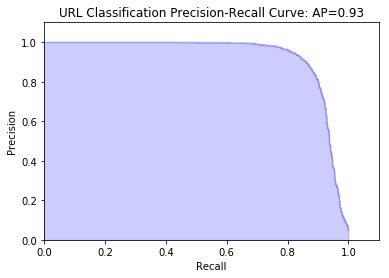

In [47]:
# 1. Compute the average_precision_score
average_precision = average_precision_score(expected, probabilities)
# 2. Create the precision-recall (PR) curve object
precision, recall, _ = precision_recall_curve(expected, probabilities)
# 3. Set parameters of the PR curve
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall') # Set axes labels
plt.ylabel('Precision')
plt.ylim([0.0, 1.1]) # Set axes limits
plt.xlim([0.0, 1.1])
plt.title('URL Classification Precision-Recall Curve: AP={0:0.2f}'.format(
          average_precision))

We hope you enjoyed this brief tour of Tensorflow walking through URL classification! To learn more, check out the following links:
1. Official Tensorflow Programming Guide: (https://www.tensorflow.org/programmers_guide/)
2. Specific tutorials on Feature Columns (https://www.tensorflow.org/get_started/feature_columns), creating custom models (https://www.tensorflow.org/get_started/custom_estimators), and much more!
3. Machine Learning to Classify Phishing URLs (https://github.com/surajr/URL-Classification)
4. Survey of ML for URL Classification (https://arxiv.org/pdf/1701.07179.pdf)